In [20]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

## Extract Dataset

In [5]:
base_dir = 'PlantVillage'

# Membaca Direktori
print("Contents of Base Directory : ")
print(os.listdir(base_dir))

# Membaca Sub-Direktori
print("\nContents of Base Directory : ")
print(os.listdir(f'{base_dir}/Training'))

# Membaca Sub-Direktori
print("\nContents of Base Directory : ")
print(os.listdir(f'{base_dir}/Validation'))


Contents of Base Directory : 
['Training', 'Validation']

Contents of Base Directory : 
['Potato Early Blight', 'Potato Healthy', 'Potato Late Blight']

Contents of Base Directory : 
['Potato Early Blight', 'Potato Healthy', 'Potato Late Blight']


## Akses Dataset

In [6]:
data_list = ['Potato Early Blight','Potato Healthy','Potato Late Blight']

for data in data_list:
    print(f'Total Training {data} Images : ', len(os.listdir(f'{base_dir}/Training/{data}')))
    
print(" ------------------------------------------------ ")

for data in data_list:
    print(f'Total Validation {data} Images : ', len(os.listdir(f'{base_dir}/Validation/{data}')))

Total Training Potato Early Blight Images :  800
Total Training Potato Healthy Images :  121
Total Training Potato Late Blight Images :  800
 ------------------------------------------------ 
Total Validation Potato Early Blight Images :  200
Total Validation Potato Healthy Images :  31
Total Validation Potato Late Blight Images :  200


## Resize Dataset 

In [7]:
from PIL import Image
import os

def resize_images(input_dir, output_dir, target_size):
    for dataset_type in ['Training', 'Validation']:
        input_dataset_dir = os.path.join(input_dir, dataset_type)
        output_dataset_dir = os.path.join(output_dir, dataset_type)

        if not os.path.exists(output_dataset_dir):
            os.makedirs(output_dataset_dir)

        for class_name in os.listdir(input_dataset_dir):
            input_class_dir = os.path.join(input_dataset_dir, class_name)
            output_class_dir = os.path.join(output_dataset_dir, class_name)

            if not os.path.exists(output_class_dir):
                os.makedirs(output_class_dir)

            for filename in os.listdir(input_class_dir):
                input_img_path = os.path.join(input_class_dir, filename)
                output_img_path = os.path.join(output_class_dir, filename)

                img = Image.open(input_img_path)
                resized_img = img.resize(target_size)
                resized_img.save(output_img_path)

input_dir = './PlantVillage/'
output_dir = './resized_PlantVillage'

# Adjust target size as needed
target_size = (224, 224)

resize_images(input_dir, output_dir, target_size)

print("Resize 224 x 224 piksel Telah Selesai Dilakukan")

Resize 224 x 224 piksel Telah Selesai Dilakukan


## Akses Data yang telah di resize 224 x 224 pixel

In [8]:
data_list = ['Potato Early Blight','Potato Healthy','Potato Late Blight']

for data in data_list:
    print(f'Total Training {data} Resize Images : ', len(os.listdir(f'{output_dir}/Training/{data}')))
    
print("======================================================")

for data in data_list:
    print(f'Total Validation {data} Resize Images : ', len(os.listdir(f'{output_dir}/Validation/{data}')))

Total Training Potato Early Blight Resize Images :  800
Total Training Potato Healthy Resize Images :  121
Total Training Potato Late Blight Resize Images :  800
Total Validation Potato Early Blight Resize Images :  200
Total Validation Potato Healthy Resize Images :  31
Total Validation Potato Late Blight Resize Images :  200


In [9]:
# Membuat Variabel baru untuk direktori resized
TRAIN_RESIZED_DIR = os.path.join(output_dir, 'Training')
VALIDATION_RESIZED_DIR = os.path.join(output_dir, 'Validation')

# Directory with training cat/dog pictures
train_early_resized_dir = os.path.join(TRAIN_RESIZED_DIR, 'Potato Early Blight')
train_healthy_resized_dir = os.path.join(TRAIN_RESIZED_DIR, 'Potato Healthy')
train_late_resized_dir = os.path.join(TRAIN_RESIZED_DIR, 'Potato Late Blight')

# Directory with validation cat/dog pictures
validation_early_resized_dir = os.path.join(VALIDATION_RESIZED_DIR, 'Potato Early Blight')
validation_healthy_resized_dir = os.path.join(VALIDATION_RESIZED_DIR, 'Potato Healthy')
validation_late_resized_dir = os.path.join(VALIDATION_RESIZED_DIR, 'Potato Late Blight')

## Data Augmentation

In [10]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    horizontal_flip =True,
    zoom_range = 0.2,
    shear_range = 0.2,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_RESIZED_DIR,
    target_size = (224, 224),
    batch_size= 32,
    shuffle = True,
    class_mode = 'categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_RESIZED_DIR,
    target_size = (224, 224),
    batch_size = 32,
    class_mode = 'categorical',
    shuffle=False,
)

Found 1721 images belonging to 3 classes.
Found 431 images belonging to 3 classes.


## Create Base Model MobileNetV2

In [11]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    )

base_model.trainable = False


In [12]:
total_params = base_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 2,257,984 total parameters in this model.
There are 0 trainable parameters in this model.


In [13]:
final_model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

final_model.summary()

tf.keras.utils.plot_model(final_model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2422339 (9.24 MB)
Trainable params: 164355

In [14]:
final_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_fit = final_model.fit(
    train_generator,
    validation_data  = validation_generator,
    epochs = 5,
    verbose = 2
)


Epoch 1/5


54/54 - 25s - loss: 0.3323 - accuracy: 0.8675 - val_loss: 0.2119 - val_accuracy: 0.9049 - 25s/epoch - 471ms/step
Epoch 2/5
54/54 - 15s - loss: 0.1255 - accuracy: 0.9593 - val_loss: 0.1124 - val_accuracy: 0.9606 - 15s/epoch - 279ms/step
Epoch 3/5
54/54 - 16s - loss: 0.0845 - accuracy: 0.9692 - val_loss: 0.1004 - val_accuracy: 0.9582 - 16s/epoch - 296ms/step
Epoch 4/5
54/54 - 16s - loss: 0.0673 - accuracy: 0.9768 - val_loss: 0.0930 - val_accuracy: 0.9582 - 16s/epoch - 289ms/step
Epoch 5/5
54/54 - 16s - loss: 0.0633 - accuracy: 0.9768 - val_loss: 0.1535 - val_accuracy: 0.9327 - 16s/epoch - 287ms/step


In [15]:
evaluation_results = final_model.evaluate(validation_generator)

print("Valid Loss : ", evaluation_results[0])
print("Valid Accuracy : ", evaluation_results[1])

14/14 [==============================] - 2s 146ms/step - loss: 0.1535 - accuracy: 0.9327
Valid Loss :  0.1534598469734192
Valid Accuracy :  0.9327146410942078


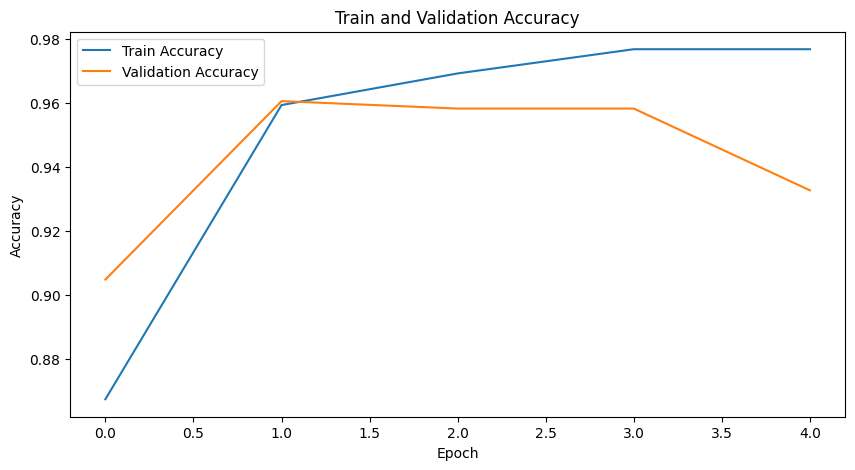

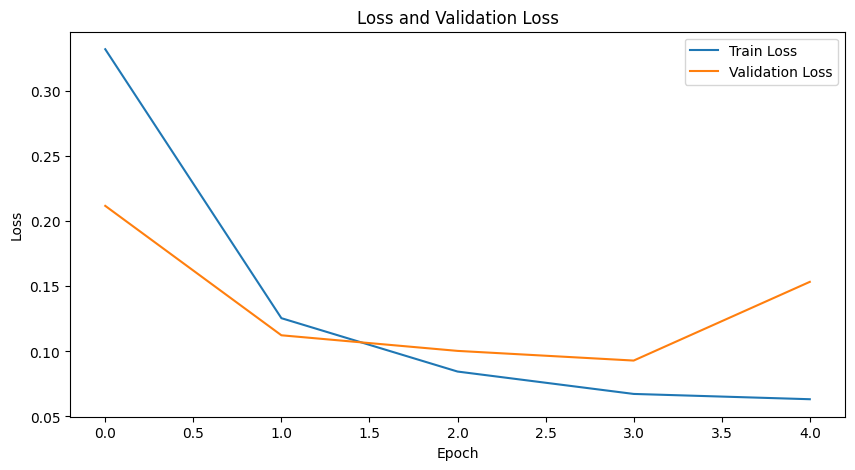

In [16]:
train_acc = model_fit.history['accuracy']
val_acc  = model_fit.history['val_accuracy']
train_loss = model_fit.history['loss']
val_loss  = model_fit.history['val_loss']

plt.figure(figsize=(10,5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [21]:
predictions = final_model.predict(validation_generator)
classes = os.listdir(TRAIN_RESIZED_DIR)

true_labels = validation_generator.classes

predicted_labels = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix MobileNetV2 : ")
print(conf_matrix)

print("\n Classification Report : ")
print(classification_report(true_labels, predicted_labels, target_names=classes))

14/14 [==============================] - 2s 160ms/step
Confusion Matrix MobileNetV2 : 
[[191   0   9]
 [  0  31   0]
 [  1  19 180]]

 Classification Report : 
                     precision    recall  f1-score   support

Potato Early Blight       0.99      0.95      0.97       200
     Potato Healthy       0.62      1.00      0.77        31
 Potato Late Blight       0.95      0.90      0.93       200

           accuracy                           0.93       431
          macro avg       0.86      0.95      0.89       431
       weighted avg       0.95      0.93      0.94       431



In [22]:
final_model.save('potato_model.h5')

c:\Users\Akazh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
